In [134]:
# import libraries

# handle dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier


from sklearn import linear_model

from imblearn.over_sampling import SMOTE
# if there is an error, solve by downgrading to install scikit-learn==1.2.2 
# ''' steps : 
# 1. install pip 
# 2. uninstall sci-kit 
# 3. uninstall imblearn
# 4. install sci-kit 1.2.2 
# 5. install imblearn 
# '''


# Data set from https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data

In [104]:
# split train test dataset 

df = pd.read_csv('Loan_Default.csv')
# remove some variables that are redundant 
# year, ID
# Interest_rate_spread and rate_of_interest are dropped due to the fact that their values are NA where the loan has defaulted 
# open credit , secured by, total units : only has one value or too few observations 
df = df.drop(['year', 'ID', 'loan_type', 'loan_purpose', 'Interest_rate_spread', 
              'rate_of_interest', 'open_credit','Upfront_charges','construction_type', 
              'Secured_by', 'Security_Type','total_units'], axis=1)
# print(df['Status'].value_counts())
# print(df.isna().sum())

# Assumption 2 : We focus on mortgage loans 
df = df.dropna(subset=["property_value"])
# Assumption 3 : drop approv in adv that is NA (only small set of samples)
# df = df.dropna(subset=["Neg_ammortization"])
df = df.dropna(subset=["term"])
df = df.dropna(subset=["loan_limit"])
df = df.dropna(subset=["approv_in_adv"])
df = df.dropna(subset=["Neg_ammortization"])
df = df.dropna(subset=["income"])


# Drop rows where sex is not available 
df = df.drop(df[df['Gender'] == 'Not Available'].index)


print("Number of rows : " , len(df.index))
# LTV = Loan to Value -> compares the loan value to the value of the asset being purchased as a part of the loan 
# Property Value 

print(df.columns)
print(df['Status'].value_counts())

        


Number of rows :  120635
Index(['loan_limit', 'Gender', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'loan_amount', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value', 'occupancy_type',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Status', 'dtir1'],
      dtype='object')
0    100978
1     19657
Name: Status, dtype: int64


In [105]:
# print(df['Neg_ammortization'].head())

# for column_name in df.columns:
#     # Count the number of NA values in the current column
#     na_count = df[column_name].isna().sum()
#     if na_count > 0 : 
#     # Print the result
#         print(f"The column '{column_name}' has {na_count} NA values.")

# print(df.columns)
print(df['loan_limit'].value_counts())


cf     112768
ncf      7867
Name: loan_limit, dtype: int64


In [106]:

categorical_columns = ['loan_limit', 'Gender', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'occupancy_type',
        'credit_type', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'Region']

for i in categorical_columns: 
    df = pd.concat([df,pd.get_dummies(df[i],drop_first=True, prefix=i)],axis=1)
    df = df.drop(i,axis=1)


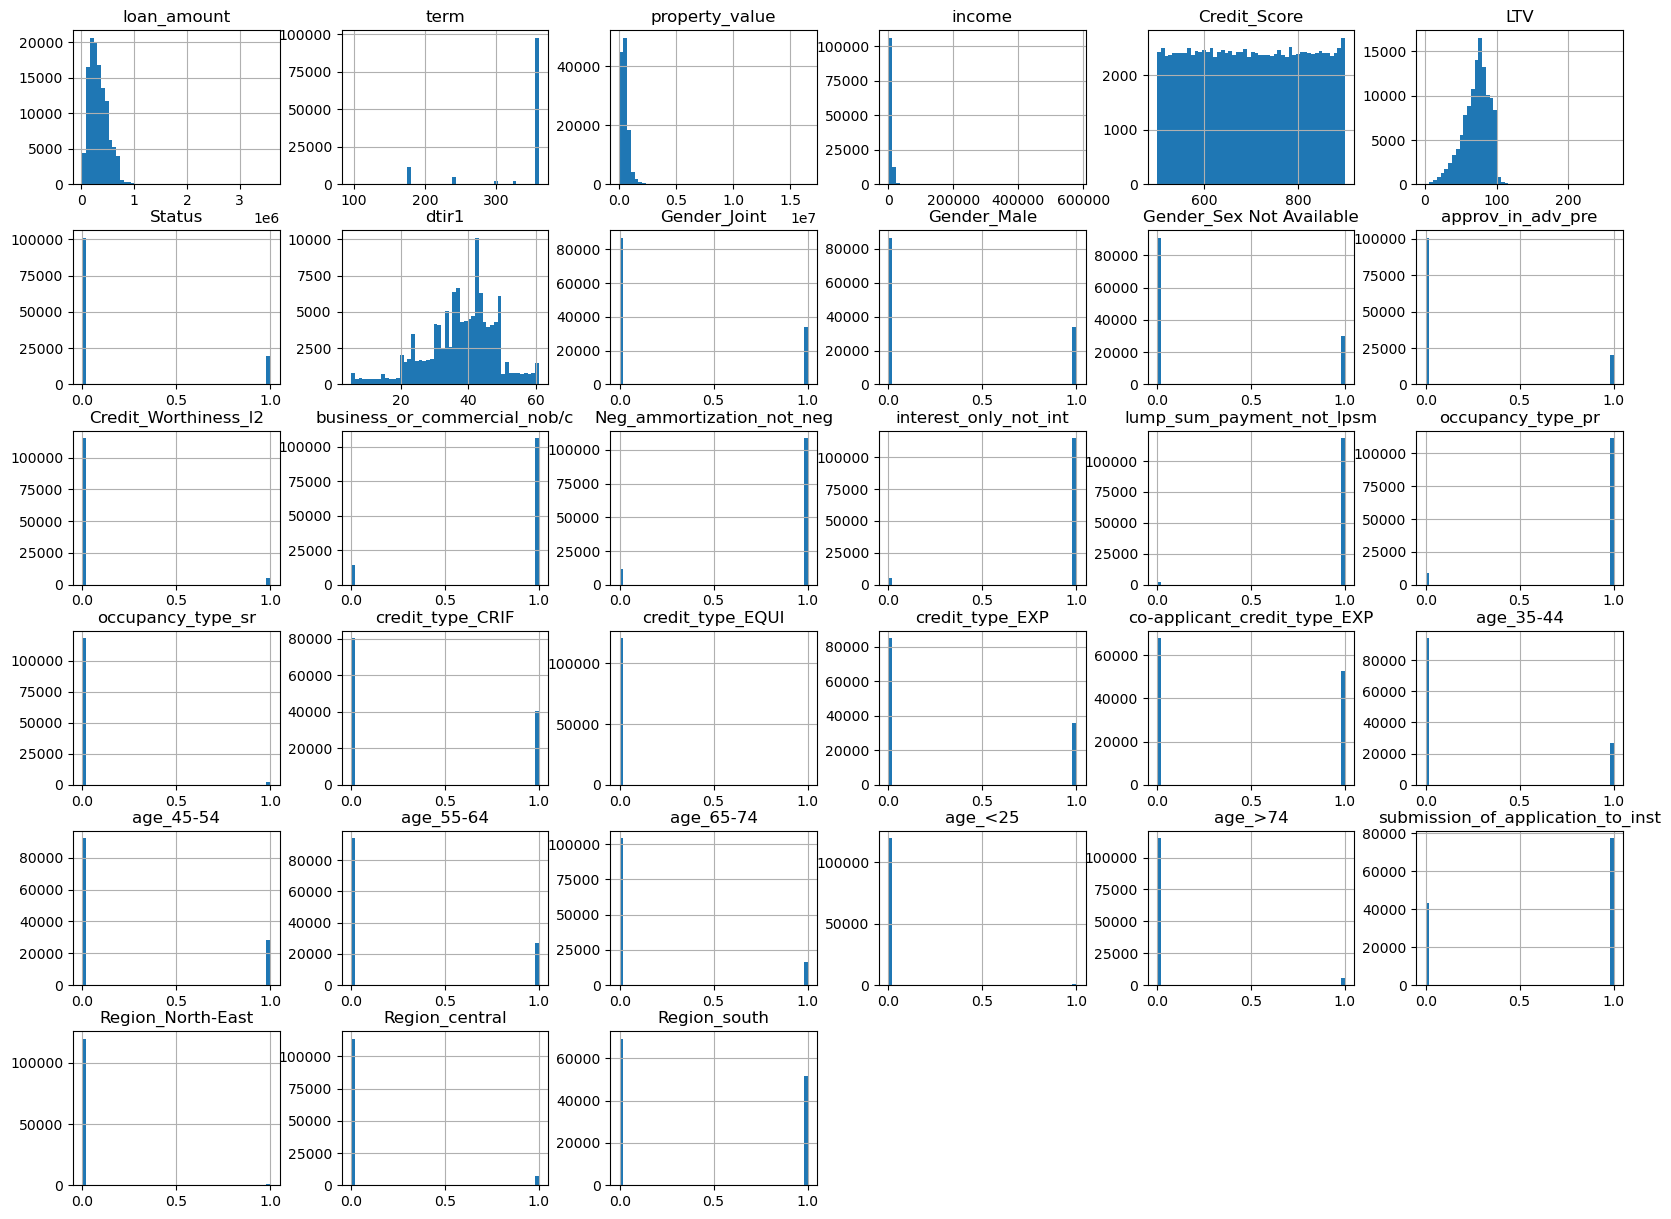

In [99]:
df.hist(bins = 50, figsize = (20, 15))
plt.show()

# Split Train Test dataset

So by looking at the data, we see there are two main types of loans : property loan and non-property loan. 


In [107]:
# define X and y variables as dataframe 
y = df['Status']
X = df.drop('Status',axis=1)
X_train, X_OOS_test, y_train, y_OOS_test = train_test_split(X, y, test_size=0.20, random_state=66)

In [136]:
# non_numeric_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns
# print("Non-numeric columns:", non_numeric_columns)

## Over Sampling 


In [109]:
# Over sample using SMOTE
# -- by inspecting the data, we see that the minority class is extremely class (fraud "Class" == 1)
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [141]:
# -- Code to Inspect the data set -- 
# df_oversampled = X_smote
# df_oversampled['Outcome_Variable'] = y_smote
# df_oversampled
# fig, ax = plt.subplots(figsize=(10, 8))
# df_oversampled['Outcome_Variable'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
# ax.set_title('Oversampled Dataset', fontsize=16)
# ax.set_ylabel('Observation counts', fontsize=14)
# ax.set_xlabel('Class', fontsize=14)
# plt.show()

print(y_smote.value_counts())


0    80809
1    80809
Name: Status, dtype: int64


In [119]:
# Set up K-Fold Cross Validation 
n_splits = 5
shuffle = True
random_state = 809
cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
# plot = plot_cv_indices(cv, X_smote, y_smote, n_splits)

## Model 1 : Logistic Regression 

In [9]:
def plot_cv_indices(cv, X, y, n_splits, lw=10):
    '''
    This function plots the Cross validation indices.
    '''
    
    fig, ax = plt.subplots(figsize = (15,8))
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['Class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [111]:
model = LogisticRegression(solver='lbfgs', max_iter=300)
model.fit(X_smote, y_smote)    
score_OOS = model.score(X_OOS_test, y_OOS_test)
print ("Logistic Model score :" , score_OOS)
y_pred = model.predict(X_OOS_test)
print("Logistic Model Recall : " , recall_score(y_OOS_test, y_pred))
print("Logistic Model Precision : ", precision_score(y_OOS_test,y_pred))
print("Probability if you only predict 0s ", 1-round(95/56867,3))

Logistic Model score : 0.5653002859866539
Logistic Model Recall :  0.634411318847903
Logistic Model Precision :  0.21736495844875348
Probability if you only predict 0s  0.998




## Model 2 : Lasso 

In [126]:
# Model 2 : LASSO 
# Cross Validate the penalty term in lasso
cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
lambdas = [0,0.001, 0.01, 0.1]
for lambda_value in lambdas:
    print('Training Lasso Lambda Value : ', lambda_value)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    lasso = linear_model.Lasso(alpha=lambda_value)
    for train_index, test_index in cv.split(X_smote):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        lasso.fit(X_cv_train, y_cv_train)
        y_pred = lasso.predict(X_cv_test)
        y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]

        #Cross-Validation Prediction Error
        score = lasso.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred_classification))
        precision_scores.append(precision_score(y_cv_test,y_pred_classification))

    cross_validate_result[lambda_value] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[lambda_value] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[lambda_value] = (sum(precision_scores)/len(precision_scores))

    print("Lambda Value Accuracy : " + str(lambda_value) + " " + str((sum(accuracies)/len(accuracies))))
    print("Lambda Value Precision : " + str(lambda_value) + " " + str((sum(recall_scores)/len(recall_scores))))
    print("Lambda Value Recall : " + str(lambda_value) + " " + str((sum(precision_scores)/len(precision_scores))))
    print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)
print(max(cross_validate_result, key=cross_validate_result.get))
    

Training Lasso Lambda Value :  0


/var/folders/df/x7ngsr_15bx8pln6jsqgdxy00000gn/T/ipykernel_34029/2559211583.py:18: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_cv_train, y_cv_train)
/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.198e+03, tolerance: 3.232e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model

Lambda Value Accuracy : 0 0.4924731795557394
Lambda Value Precision : 0 0.7869532292812949
Lambda Value Recall : 0 0.8769517497288936

Training Lasso Lambda Value :  0.001
Lambda Value Accuracy : 0.001 0.490208479329176
Lambda Value Precision : 0.001 0.7885123026124378
Lambda Value Recall : 0.001 0.8743121394471272

Training Lasso Lambda Value :  0.01
Lambda Value Accuracy : 0.01 0.42957536246474304
Lambda Value Precision : 0.01 0.7914378353713726
Lambda Value Recall : 0.01 0.8454593091922291

Training Lasso Lambda Value :  0.1
Lambda Value Accuracy : 0.1 0.036879230999902354
Lambda Value Precision : 0.1 0.6013263278617567
Lambda Value Recall : 0.1 0.5901291493096974

------------------
Accuracy :  {0: 0.4924731795557394, 0.001: 0.490208479329176, 0.01: 0.42957536246474304, 0.1: 0.036879230999902354}
Precision :  {0: 0.8769517497288936, 0.001: 0.8743121394471272, 0.01: 0.8454593091922291, 0.1: 0.5901291493096974}
Recall :  {0: 0.7869532292812949, 0.001: 0.7885123026124378, 0.01: 0.7914

In [127]:
# Somehow LASSO is performing worse?
ols = linear_model.LinearRegression()
ols.fit(X_smote, y_smote)    
y_pred = ols.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("OLS Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("OLS Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# LASSO 
lasso = linear_model.Lasso()
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("LASSO Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# RIDGE
ridge = linear_model.Ridge(alpha=1)
ridge.fit(X_smote, y_smote)
y_pred = ridge.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("Ridge Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("Ridge Model Precision : ", precision_score(y_OOS_test,y_pred_classification))

OLS Model Recall :  0.18342597271349168
OLS Model Precision :  0.24568527918781727
--
LASSO score : 
LASSO Model Recall :  0.7170288024254674
LASSO Model Precision :  0.19925577476655199
--
Ridge Model Recall :  0.18342597271349168
Ridge Model Precision :  0.24568527918781727


/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.92211e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## Cross Validate value of LASSO 

In [120]:
lasso = linear_model.Lasso()
param_grid = [{'alpha': [0.01, 0.1]}]
grid_cv = GridSearchCV(estimator=lasso, cv=cv, param_grid=param_grid, n_jobs = -1)
grid_cv.fit(X_smote, y_smote)

GridSearchCV(cv=KFold(n_splits=5, random_state=809, shuffle=True),
             estimator=Lasso(), n_jobs=-1, param_grid=[{'alpha': [0.01, 0.1]}])

In [121]:
print(grid_cv.best_estimator_)


Lasso(alpha=0.01)


# Random Forest

In [128]:

random_forest = RandomForestClassifier(n_estimators = 50, max_depth=2, random_state=0)
random_forest.fit(X_smote, y_smote)

y_pred = random_forest.predict(X_OOS_test)
print("RND Forest Model Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))

RND Forest Model Recall :  0.41611925214754925
RND Forest Precision :  0.28455425017277125


In [ ]:
# Cross Validate Random Forest
param_grid = [{'n_estimators': [200,225,250], 'max_depth' :[10,20,30]}]
random_forest_cv = RandomForestClassifier()
grid_cv = GridSearchCV(estimator=random_forest_cv, cv=cv, param_grid=param_grid, n_jobs = 3)
grid_cv.fit(X_smote, y_smote)

## KNN 

In [135]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_smote, y_smote)
# Make predictions on the test data
y_pred = knn.predict(X_OOS_test)
# Evaluate the accuracy of the classifier
print("KNN Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("KNN Recall : " , recall_score(y_OOS_test, y_pred))
print("KNN Precision : ", precision_score(y_OOS_test,y_pred))

KNN Accuracy :  0.7433166162390683
KNN Recall :  0.264022233451238
KNN Precision :  0.24161849710982658
